In [3]:
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
from Bio import SeqIO
from collections import Counter
import matplotlib.pyplot as plt
from glob import glob
import json
import sys

sys.path.append('/home/groups/dpwall/briannac/alt_haplotypes/src/localize')

from MLE import *

PHASINGS_DIR='/home/groups/dpwall/briannac/alt_haplotypes/data/phasings/'
BAM_MAPPINGS_FILE = '/home/groups/dpwall/briannac/general_data/bam_mappings.csv'
KMER_COUNTS_FILE = '/home/groups/dpwall/briannac/alt_haplotypes/results/simulated_data/kmer_counts.tsv'


# Load Data

In [4]:
# Load in family region/global region conversion data.
fam_region_to_idx = np.load(PHASINGS_DIR +  'fam_region_to_idx.npy', allow_pickle=True).item()
idx_to_fam_region = np.load(PHASINGS_DIR +  'idx_to_fam_region.npy', allow_pickle=True).item()
global_region_to_idx = np.load(PHASINGS_DIR +  'global_region_to_idx.npy', allow_pickle=True).item()
idx_to_global_region = np.load(PHASINGS_DIR +  'idx_to_global_region.npy', allow_pickle=True).item()
fam_idx_to_global_idx = np.load(PHASINGS_DIR + 'fam_regions_to_global_regions.npy', allow_pickle=True)
family_info = pd.read_pickle(PHASINGS_DIR + 'fam_list.df')

# Info from BAM mappings.
bam_mappings = pd.read_csv(BAM_MAPPINGS_FILE, sep='\t', index_col=1)
bam_mappings = bam_mappings[bam_mappings['status']=='Passed_QC_analysis_ready']


## Simulated k-mer counts.

In [3]:
kmer_counts = pd.read_table(KMER_COUNTS_FILE, index_col=0)
kmer_counts = kmer_counts[((kmer_counts>0).mean(axis=1)>.05) & ((kmer_counts>0).mean(axis=1)<.5)]
kmer_counts.index = [(int(i.split(',')[0].replace('(', '')), float(i.split(',')[1].replace(')', ''))) for i in kmer_counts.index]


## Alternative Haplotypes from Decoy Sequence

In [10]:
# Load in k-mer counts.
KMERS_FILE = '/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/ground_truth/sample_kmer_matrix/known_alt_haplotype_kmers_filt.txt'
KMER_COUNTS_FILE = '/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/ground_truth/sample_kmer_matrix/kmers.filt.tsv'

ref_genome = {r.id:r.description.split('  ')[4].replace('rg:', '') for r in SeqIO.parse(
    '/home/groups/dpwall/briannac/general_data/reference_genomes/GRCh38_reference_genome/GRCh38_full_analysis_set_plus_decoy_hla.fa', 'fasta') if 'alt' in r.id}

kmer_counts = pd.read_table(KMER_COUNTS_FILE, header=None, index_col=0, nrows=100000, skiprows=10000)
kmer_names = pd.read_table(KMERS_FILE, header=None, index_col=0, nrows=100000, skiprows=10000)
kmer_counts.index = [(i,ref_genome[j]) for i,j in zip(kmer_names.index, kmer_names[1])]
kmer_counts.columns = bam_mappings.index
kmer_counts = kmer_counts[((kmer_counts>0).mean(axis=1)>.05) & ((kmer_counts>0).mean(axis=1)<.5)]


In [13]:
# Normalize k-mer counts by average sample depth.

kmer_length=100
PARENT_DIR = '/home/groups/dpwall/briannac/blood_microbiome/'
ihart_flagstat_file = PARENT_DIR + 'data/ihart_flagstat.csv'
flagstat = pd.read_csv(ihart_flagstat_file, index_col=0)
flagstat = flagstat.loc[set(flagstat.index).intersection(bam_mappings.index)]
bam_mappings = bam_mappings.loc[flagstat.index]
total_mapped_reads = flagstat.ProperPair*((flagstat.Total_Reads-flagstat.Supplementary-flagstat.Duplicates)/flagstat.Total_Reads)
avg_coverage = total_mapped_reads*150/(6.27e9*(bam_mappings.sex_numeric.astype(float)==1.0) + 6.37e9*(bam_mappings.sex_numeric.astype(float)==2.0))
avg_n_100mers = (150-kmer_length)/(150/avg_coverage)
kmer_depth_dict = {k:avg_n_100mers[k] for k in avg_n_100mers.keys()}
kmer_counts = kmer_counts[flagstat.index]

avg_k_depth = np.mean(list(kmer_depth_dict.values()))
norm_mult = np.array([avg_k_depth/kmer_depth_dict[c] for c in kmer_counts.columns])
kmer_counts_normed = kmer_counts.apply(lambda x: round(x*norm_mult), axis=1).astype(int)

In [34]:
avg_k_depth

5.834855303941777

In [32]:
from scipy.stats import poisson
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
from Bio import SeqIO
from collections import Counter
import matplotlib.pyplot as plt
from glob import glob
import json
import pickle

def GlobalInterval(L, std_thresh=1)
    '''
        Returns the the smallest and largest position where the likelihood is <=1 standard deivation away from the maximum likelihood.
                Parameters:
                        L (array): Array of likelihoods for each global genomic region.
                        std_thresh (float): Number of standard deviations away from the maximum likelihood to consider.

                Returns:
                        interval (tuple): The start and end idxs.
        '''    
    thresh = np.max(L) - std_thresh*np.std(L)
    if len(np.where(L>thresh)[0])==0: return (0, 100000)
    start = np.where(L>thresh)[0][0]
    end = np.where(L>thresh)[0][-1]
    return (start, end)




class MLE:
    def __init__(self, avg_kmer_depth, poisson_cache_length, eps=0, phasing_error=.05):
        self.poisson_cache = [[], []]
        self.avg_kmer_depth=avg_kmer_depth
        self.poisson_cache[0] = [poisson.pmf(k=k, mu=avg_kmer_depth) for k in range(poisson_cache_length)]
        self.poisson_cache[1] = [poisson.pmf(k=k, mu=2*avg_kmer_depth) for k in range(poisson_cache_length)]
        self.cached_family_log_likelihood = dict()
        self.eps = eps
        self.phasing_error=phasing_error
        with open('/home/groups/dpwall/briannac/alt_haplotypes/data/phasings/phased_fams/phased_fams_all.pickle', 'rb') as f:
            self.phased_fam_dict = pickle.load(f)
        with open('/home/groups/dpwall/briannac/alt_haplotypes/data/localize/family_probability_cache.pickle', 'rb') as f:
            self.family_probability_cache = pickle.load(f)

            
    def cached_poisson_pmf(self,k,g):
        if (g==0) & (k!=0):
            return self.eps
        if (k==0) & (g==0): 
            return 1-3*self.eps #poisson.pmf(g*avg_kmer_depth, k)
        else:
            return min(max(self.poisson_cache[g-1][k], self.eps), 1-3*self.eps)
    
    
    
    
    
    def family_log_likelihood(self,k_m, k_p, k_cs, phases_ch):

        '''
        Returns the probability of a k-mer distribution in a family given the each member's kmer counts and the children's phasings. Note: takes about 1 second per 50K family-regions.

                Parameters:
                        k_m (int): mom_kmer_count (int): A decimal integer
                        k_p (int): dad_kmer_count (int): Another decimal integer
                        phases_ch (list): A list of of tuples representing each child's phasings (mom's chromome, dad's chromosme) {(0,0), (0,1), (1,0), (1,1)}
                        avg_kmer_depth (int): Mean for avg k-mer depth of poisson distribution.

                Returns:
                        log likelihood (float): The log of the probability of the family's k-mer distribution given the famiy genotypes.
        '''    
        key = (k_m, k_p, tuple(k_cs.values()), phases_ch)
        if key in self.family_probability_cache: return self.family_probability_cache[key]
        else: return eps
        
        #key = tuple(sorted([(k_m, k_p, k,g[0], g[1]) for k,g in zip(k_cs, phases_ch)]))
        #key = (k_m, k_p, tuple(k_cs.values), phases_ch) #tuple([(k_m, k_p, k,g[0], g[1]) for k,g in zip(k_cs, phases_ch)])
        #if key not in self.family_probability_cache: return np.log2(.00001)
        #else: return self.family_probability_cache[key]
        # TODO ADD TO KEY
        #if key in self.cached_family_log_likelihood: log_P = self.cached_family_log_likelihood[key]
        #else:
        #if True:
        #    possible_gs = [(0,0), (1,1), (0,1), (1,0)]
            #log_P_m = np.log2(sum([self.cached_poisson_pmf(k_m, g) for g in [0,1,1,2]]))
            #log_P_p= np.log2(sum([self.cached_poisson_pmf(k_p, g) for g in [0,1,1,2]]))
            #pdb.set_trace()
       #     log_P_ch = np.log2(sum([self.cached_poisson_pmf(k_m,sum(g_m))*self.cached_poisson_pmf(k_p,sum(g_p))*
                                    np.prod([self.cached_poisson_pmf(k_c, g_m[phase_ch[0]]+g_p[phase_ch[1]]) 
                                             for k_c, phase_ch in zip(k_cs, phases_ch)]) for g_p in possible_gs for g_m in possible_gs]))
        #    log_P = log_P_ch#-log_P_m-log_P_p
            #self.cached_family_log_likelihood[key] = log_P

        #    if log_P>0: print("ERROR: log likelihood cannot be > 0")
        #return log_P
    
    
    def GlobalLikelihood(self,kmer_count, bam_mappings, family_info, global_region_to_idx, fam_region_to_idx, fam_idx_to_global_idx, MAX_FAMS=None):
        global_likelihoods = [] #np.zeros(len(global_region_to_idx)) 
        fams_included = set(bam_mappings.loc[np.array(kmer_count[1].keys())[kmer_count[1].values>0]].family).intersection(self.phased_fam_dict.keys())
        if MAX_FAMS: fams_included = list(fams_included)[:min(MAX_FAMS, len(fams_included))]
        for fam in fams_included:
            
            # Initialize global likelihood
            global_likelihood = np.zeros(len(global_region_to_idx)) 


            # Extract mom, dad, and child sample_ids.
            children = family_info.loc[fam].sib_samples
            mom = family_info.loc[fam].mother_sample
            dad = family_info.loc[fam].father_sample
            phased_fam = self.phased_fam_dict[fam]
            
            fam_bad = False
            if mom not in bam_mappings.index: continue
            if dad not in bam_mappings.index: continue
            for ch in children:
                if ch not in bam_mappings.index:
                    fam_bad = True
                    break
            if fam_bad: continue

            # Compute likelihood of family's k-mer distribution for each phasing configuration.
            fam_likelihood = np.zeros(len(phased_fam))
            phasings = [tuple(phased_fam[children].iloc[i].values) for i in range(len(phased_fam))]
            possible_phasings = set(phasings)

            phasing_ps = np.array([self.family_log_likelihood(kmer_count[1][mom], kmer_count[1][dad], kmer_count[1][children].values, phase) 
                          for phase in possible_phasings])
            #phasing_ps = self.phasing_error*(sum(phasing_ps) - phasing_ps) + (1-self.phasing_error)*phasing_ps
            for phase, phase_p in zip(possible_phasings, phasing_ps):   
                idx = np.where([p==phase for p in phasings])[0]
                fam_likelihood[idx] = phase_p
            
            
            #for phase in possible_phasings:
            #    idx = np.where([p==phase for p in phasings])[0]
            #    fam_likelihood[idx] = self.family_log_likelihood(kmer_count[1][mom], kmer_count[1][dad], kmer_count[1][children], phase) #for i in range(len(phased_fam))
            #print(min(fam_likelihood), max(fam_likelihood))
            
            
            # Convert family likelihood region to global region. 
            for i,l in enumerate(fam_likelihood):
                global_idxs = fam_idx_to_global_idx[fam_region_to_idx[phased_fam.index[i]]]
                global_likelihood[global_idxs] =  l
                
            # For regions with unknown phasings in the current family, default to the median likelihood across the rest of the genome.
            global_likelihood[global_likelihood==0] = np.median(global_likelihood[global_likelihood!=0])
            global_likelihoods = global_likelihoods + [global_likelihood]

        return np.array(global_likelihoods).sum(axis=0)


AU3154 is not all in here...
AU2410 is not all in here...
True Location: chr1:144488706-144674781 Could not localize k-mer.


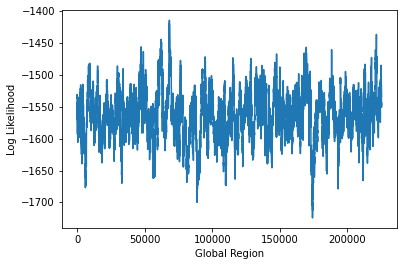

True Location: chr1:198370083-198725175 Could not localize k-mer.


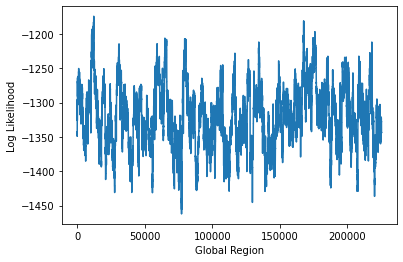

AU3154 is not all in here...
AU2410 is not all in here...
True Location: chr1:198370083-198725175 Predicted Region: 01.195186163 - 01.201069559


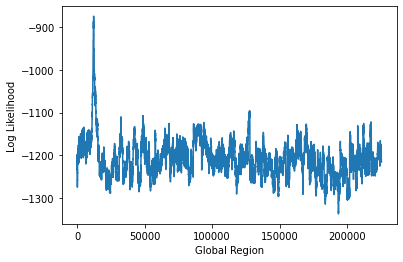

AU3154 is not all in here...
AU2410 is not all in here...
True Location: chr1:198370083-198725175 Predicted Region: 01.193545204 - 01.200217159


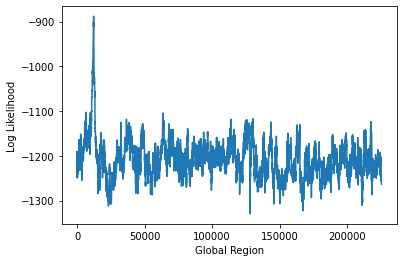

AU3154 is not all in here...
True Location: chr1:234163457-234211370 Could not localize k-mer.


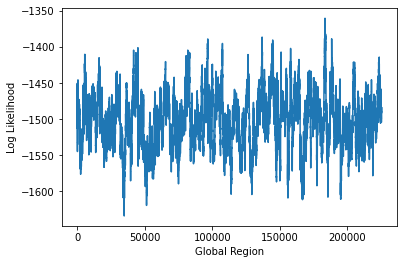

AU2410 is not all in here...
True Location: chr2:728878-860300 Predicted Region: 02.000000001 - 02.005406157


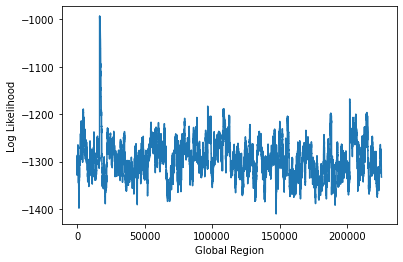

True Location: chr2:728878-860300 Could not localize k-mer.


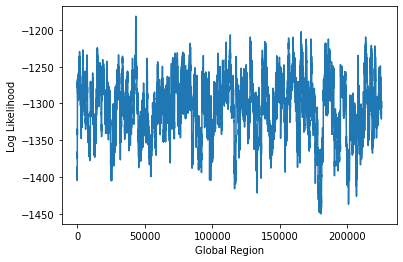

AU2410 is not all in here...
True Location: chr2:1315177-1541254 Could not localize k-mer.


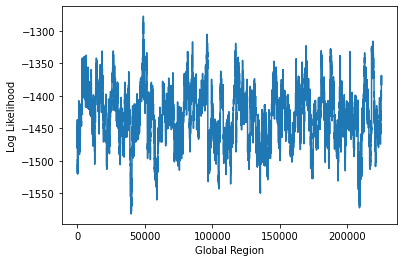

AU2410 is not all in here...
True Location: chr2:3391898-3511146 Predicted Region: 02.000000001 - 02.005574287


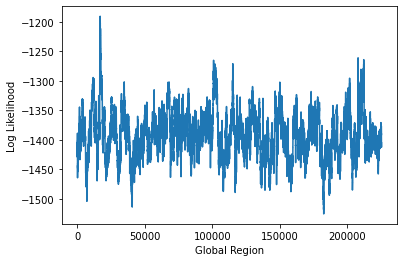

AU2410 is not all in here...
True Location: chr2:3391898-3511146 Predicted Region: 02.002244686 - 02.004246696


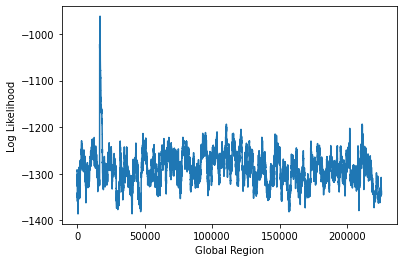

True Location: chr2:3391898-3511146 Predicted Region: 02.002290169 - 02.004766900


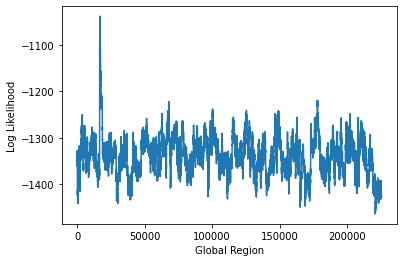

AU2410 is not all in here...
True Location: chr2:90269482-90402511 Could not localize k-mer.


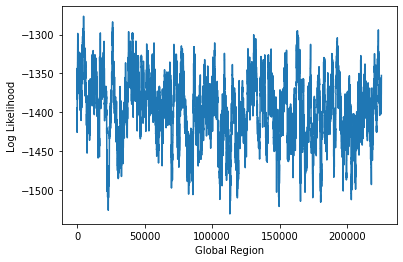

AU3051 is not all in here...


KeyboardInterrupt: 

In [33]:
mle = MLE(5.83, 100, eps=0, phasing_error=0)
aa = []
for k in kmer_counts_normed.iloc[::1000].iterrows():
    a = mle.GlobalLikelihood(k, bam_mappings, family_info,
                         global_region_to_idx, fam_region_to_idx, fam_idx_to_global_idx,MAX_FAMS=100)
    aa = aa + [a]
    start, end = GlobalInterval(a, .95)
    if idx_to_global_region[start][:2]!=idx_to_global_region[end][:2]:
        print('True Location:',  k[0][1], 'Could not localize k-mer.')
    else:
        print('True Location:',  k[0][1], 'Predicted Region:', 
          '.'.join(idx_to_global_region[start].split('.')[:2]), '-', '.'.join(np.array(idx_to_global_region[end].split('.'))[[0,2]]))
    plt.plot(a)
    plt.ylabel('Log Likelihood')
    plt.xlabel('Global Region')
    plt.show()